# Transformer Neural Networks - Understanding

## 1. Overall Transformer Neural Networks Architecture

![Transformer Architect Image](./img/transformerarchitect.png)

As we see, the overall architecture of the Transformer is in the upper part. It is probably quite difficult to understand the detailed picture so we need a broader picture. Let's see the next picture!

![Transformer Architect Image](./img/transformerblock.png)

1. Input/Output Pre-processing

Token Embeddings
- **Function**: Converts each token in the input sequence into a dense vector of fixed size (commonly 512 dimensions).
- **Implementation**: An embedding layer maps each token to a dense vector.

Positional Encodings
- **Function**: Adds information about the position of each token in the sequence to the token embeddings, since the Transformer architecture does not inherently capture sequence order.
- **Implementation**: Sinusoidal functions are used to generate positional encodings, which are then added to the token embeddings.

2. Encoder

Processes the input sequence with a stack of identical layers. Each layer consists of:

Multi-Head Self-Attention
- **Function**: Allows each token to attend to all other tokens in the sequence, capturing dependencies regardless of their distance in the sequence.
- **Implementation**: Multiple attention heads operate in parallel to learn different aspects of the input.

Add & Norm
- **Function**: Adds the input of each sub-layer to its output (residual connection) and applies layer normalization to stabilize and speed up training.
- **Implementation**: Addition followed by normalization.

Feed-Forward
- **Function**: Applies a fully connected feed-forward network to each position independently and identically.
- **Implementation**: Two linear transformations with a ReLU activation in between.

3. Decoder

Generates the output sequence from the encoded input using a stack of identical layers. Each layer consists of:

Masked Multi-Head Self-Attention
- **Function**: Prevents attending to future tokens in the sequence during training (autoregressive property).
- **Implementation**: Similar to the encoder's self-attention but with a mask to prevent future token attention.

Multi-Head Attention over Encoder’s Output
- **Function**: Allows each position in the decoder to attend to all positions in the encoder's output.
- **Implementation**: Standard multi-head attention mechanism applied to the encoder’s output.

Add & Norm
- **Function**: Similar to the encoder's Add & Norm, it adds residual connections and normalizes the output.
- **Implementation**: Addition followed by normalization.

Feed-Forward
- **Function**: Similar to the encoder's feed-forward network.
- **Implementation**: Two linear transformations with a ReLU activation in between.

4. Output Post-processing

**Function**
- Transforms the decoder’s output into probabilities over the vocabulary.

**Implementation**
- A linear layer followed by a softmax function.

## 2. Detailed architecture we need to know

In [1]:
# import library
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using GPU.")
    print("Number of GPUs available: ", torch.cuda.device_count())
    print("GPU name: ", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch is using CPU.")

CUDA is available. PyTorch is using GPU.
Number of GPUs available:  1
GPU name:  NVIDIA GeForce GTX 1650


### 2.1. Token Embedding

In this section we will learn about Embedding Layer in Transformer architecture.

First, we can imagine the embedding layer as a table / matrix used for lookup. The shape of that layer is (Number of words in the vocabulary) x (Number of dimensions we want, usually 512)

So, every token (word) will be looked up in that embedding layer and take out the row/column related. The embedding vectors will be ready!

![Input Embedding Block](./img/inputembedding.png)

In [4]:
# Create a embedding layer from torch.nn
vocabulary_size = 1000
dim_model = 512
embedding_layer = nn.Embedding(vocabulary_size,dim_model)
embedding_layer.weight

Parameter containing:
tensor([[-1.1103,  0.2737, -1.1923,  ...,  0.0517,  1.1469,  0.9174],
        [ 1.5620,  1.2486,  0.8559,  ...,  0.2693, -0.0744,  1.0542],
        [-1.1299, -0.7354, -1.3687,  ...,  1.7776,  0.1688, -1.0859],
        ...,
        [ 1.2343,  1.1962,  0.8683,  ..., -0.9005, -0.0058, -1.5062],
        [ 0.9266,  0.6423,  1.4722,  ..., -0.8630, -0.3882,  0.1390],
        [ 2.0523, -0.3437, -0.9781,  ...,  1.0112, -0.8111, -1.3046]],
       requires_grad=True)

In [5]:
# Up to our setup, we don't need onehot ! we can use dictionary,...
sequence = torch.tensor([23,54,28,85])
embedding_layer(sequence)

tensor([[-0.3068,  0.1850, -0.1875,  ..., -0.2330, -0.5825,  1.4147],
        [ 0.0748,  0.2406, -0.5015,  ..., -0.0950, -0.9105, -0.7992],
        [ 0.3021,  0.1141, -0.5778,  ..., -0.6256,  0.3716,  1.3130],
        [-0.4486,  1.1237, -0.8492,  ..., -0.2855, -0.5507, -0.6350]],
       grad_fn=<EmbeddingBackward0>)

### 2.2. Positional Encoding Block

Do you get stuck in the question "What are the differences between the same tokens (words) in the sequence after embedding?" ?

So, Positional Encoding Block is here to help us. This block simply means show the positional feature of each tokens (words) in the sequence.

For example:

![Positional Encoding Block](./img/positionalencoding.png)

Recipe:

$$
PE(\text{position}, 2i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$

$$
PE(\text{position}, 2i+1) = \cos\bigg( \frac{ \text{position} }{10000^\frac{2i}{d_{model}}} \bigg)
$$

We can rewrite these as

$$
PE(\text{position}, i) = \sin\bigg( \frac{ \text{position} }{10000^\frac{i}{d_{model}}} \bigg) \text{ when i is even}
$$

$$
PE(\text{position}, i) = \cos\bigg( \frac{ \text{position} }{10000^\frac{i-1}{d_{model}}} \bigg) \text{ when i is odd}
$$

In [6]:
# example
dim_model = 512
sequence_length = 10

In [7]:
even = torch.arange(0,dim_model,2).float()
odd = torch.arange(1,dim_model,2).float()

even = torch.pow(10000,even/dim_model)
odd = torch.pow(10000,(odd-1)/dim_model)
print(even[:3])
print(odd[:3])

tensor([1.0000, 1.0366, 1.0746])
tensor([1.0000, 1.0366, 1.0746])


In [8]:
position = torch.arange(0,sequence_length,1).unsqueeze(1)
PE = torch.zeros(sequence_length,dim_model)

In [9]:
PE[:,0::2] = torch.sin(position / even)
PE[:,1::2] = torch.cos(position / odd)
PE.shape

torch.Size([10, 512])

In [10]:
PE

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 6.5699e-01,  7.5390e-01,  4.5239e-01,  ...,  1.0000e+00,
          7.2564e-04,  1.0000e+00],
        [ 9.8936e-01, -1.4550e-01,  9.9067e-01,  ...,  1.0000e+00,
          8.2931e-04,  1.0000e+00],
        [ 4.1212e-01, -9.1113e-01,  6.7637e-01,  ...,  1.0000e+00,
          9.3297e-04,  1.0000e+00]])

### 2.3. Query - Key - Value Layer

Taking the output of Input Pre-processing, we analyze it into Query, Key, Value through a linear layer.

In [11]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )
x.shape

torch.Size([1, 4, 512])

In [12]:
qkv_layer = nn.Linear(input_dim , 3 * dim_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

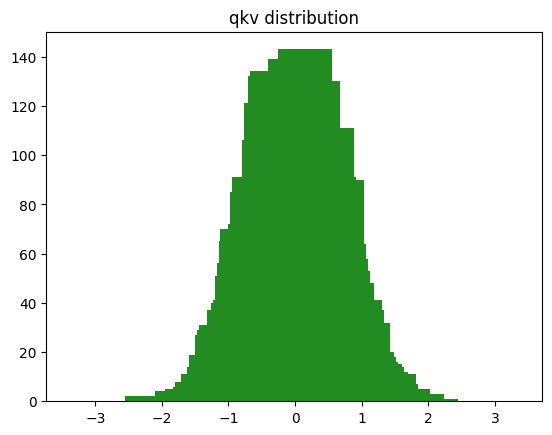

In [13]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [14]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [15]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [16]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### 2.4. Multi-Head Attention Block

![Encoder](./img/multihead-attention.png)

With input include:
> - Query: What we are looking for
> - Key: What we can offer for
> - Value: What we actually offer for

With output include:
> - New Value

In [17]:
# We need Query, Key, Value For Example
sequence_length , k_dim, v_dim = 5 , 10 , 10
q = torch.randn(sequence_length, k_dim)
k = torch.randn(sequence_length, k_dim)
v = torch.randn(sequence_length, v_dim)

In [18]:
print(q)
print(k)
print(v)

tensor([[-0.7563, -1.6927,  0.3938,  0.0727, -0.5129, -0.3881,  0.9526, -1.1354,
         -0.0817,  1.5666],
        [-1.1798, -0.1515,  0.1284, -0.0469,  0.4387, -1.8406,  1.8743, -0.9029,
          1.6134,  1.2564],
        [-0.1095,  0.3560,  0.9792,  1.0643,  0.0349,  0.2580,  1.4366, -0.6842,
          1.3477,  0.0518],
        [ 0.2245, -0.4452,  0.9874, -0.3315,  0.0893, -1.8487,  1.4821, -2.5856,
         -1.2882, -0.9652],
        [ 0.3575,  0.8580, -1.6130, -1.3930,  0.3830,  2.0177, -0.3412,  0.8444,
         -0.1111,  0.0419]])
tensor([[-0.9846,  0.4916, -1.9471, -0.7256, -1.2736, -0.7251, -1.0818,  0.2569,
         -1.7890,  1.6660],
        [-0.4023,  0.2905,  0.1299, -1.0648,  0.5816,  0.0410,  1.1383,  0.2743,
          1.1843, -1.7954],
        [ 1.3223,  0.6153,  0.3686,  0.5268, -1.7266,  0.0336,  0.2941,  0.0109,
          0.4794, -2.3649],
        [-0.6343, -0.4349, -2.7276,  0.1323,  0.1060,  0.8087, -0.3457, -0.2589,
          0.0830, -1.3636],
        [-1.6026, 

- Scaled Dot-Product Attention:
Funtion:

$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

Q,K,V -(1)-> Matmul(Q,K.T) -(2)-> Scale -(3)-> Masking (Not Required for Encode) -(4)-> Softmax -(5)-> Matmul (. ,V) -> new V

In [19]:
# Step 1: calculate Q.K_t
step1 = torch.matmul(q,k.t())
step1

tensor([[ 1.4616, -2.6645, -4.4619, -2.3954,  1.9924],
        [-1.4057,  2.2176, -4.1063, -2.9778,  8.0894],
        [-6.6821,  2.1228,  1.8828, -2.6815,  1.1988],
        [-2.4664,  1.4231,  2.0690, -2.8055,  3.1390],
        [ 3.1250,  1.3210, -1.1648,  5.1207, -2.3879]])

In [20]:
# Step 2: Scale
# Check variance
q.var(), k.var(), step1.var()

(tensor(1.1333), tensor(1.0353), tensor(11.3793))

As we see, the variance distance between Q, K, matmul(Q,K.T) is very high. We have to scale again so that the softmax function can work effectively, creating a probability distribution.

In [21]:
step2 = step1 / math.sqrt(k_dim)
step2

tensor([[ 0.4622, -0.8426, -1.4110, -0.7575,  0.6301],
        [-0.4445,  0.7013, -1.2985, -0.9417,  2.5581],
        [-2.1131,  0.6713,  0.5954, -0.8480,  0.3791],
        [-0.7799,  0.4500,  0.6543, -0.8872,  0.9926],
        [ 0.9882,  0.4177, -0.3684,  1.6193, -0.7551]])

But **why** is **the number of Key dimension** and **why** use **square** ?

Dividing by the square root of the dimension of the weight vector (in this case k_dim) has an important meaning.

Specifically, in the Multi-Head Attention mechanism, after calculating attention scores, we will apply the softmax function to normalize these scores into a probability distribution. Dividing each score by the square root of k_dim helps control the amplitudes of the scores, preventing them from becoming too large or too small. This improves model stability and performance.

In [22]:
# Step 3: Masking
# This is not required in the encoding block but it is required in the decoding block
# Masking is used to make sure that the current word/ token/ ... doesn't take the context from the future / generated word. That is cheating!!!!
mask = torch.tril(torch.ones(sequence_length,sequence_length))
mask

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [23]:
# mask filter
step3 = torch.tril(step2)
step3

tensor([[ 0.4622,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.4445,  0.7013,  0.0000,  0.0000,  0.0000],
        [-2.1131,  0.6713,  0.5954,  0.0000,  0.0000],
        [-0.7799,  0.4500,  0.6543, -0.8872,  0.0000],
        [ 0.9882,  0.4177, -0.3684,  1.6193, -0.7551]])

In [24]:
step3 = torch.where(step3 == 0, float('-inf'), step3)
step3

tensor([[ 0.4622,    -inf,    -inf,    -inf,    -inf],
        [-0.4445,  0.7013,    -inf,    -inf,    -inf],
        [-2.1131,  0.6713,  0.5954,    -inf,    -inf],
        [-0.7799,  0.4500,  0.6543, -0.8872,    -inf],
        [ 0.9882,  0.4177, -0.3684,  1.6193, -0.7551]])

**Why** is '-inf' ?

When we take this to the Softmax Function(x), $e^{x}$ will go to value '0' if x goes to '-inf'. Otherwise, The value '0' will result in $e^{x}$ equals 1!!!

$$
\text{softmax} = \frac{e^{x_i}}{\sum_j e^{x_j}}
$$

In [25]:
# Step 4: Softmax
step4 = (torch.exp(step3).t() / torch.sum(torch.exp(step3),axis=-1)).t()
step4

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2413, 0.7587, 0.0000, 0.0000, 0.0000],
        [0.0311, 0.5028, 0.4661, 0.0000, 0.0000],
        [0.1051, 0.3595, 0.4410, 0.0944, 0.0000],
        [0.2579, 0.1458, 0.0664, 0.4848, 0.0451]])

In [26]:
# Step5: matmul(.,V)
step5 = torch.matmul(step4, v)
step5

tensor([[ 1.2191,  1.4067,  0.4907, -0.1601, -1.2290, -1.9466, -0.4770,  0.8731,
         -1.1765, -0.7147],
        [-0.3000,  0.4343, -0.1135,  0.4237,  0.3444, -0.6155,  0.8298,  1.0197,
         -0.0692, -0.3532],
        [-0.2396, -0.6206,  0.6749,  0.4681, -0.1867,  0.8412,  0.3672, -0.0421,
         -0.1994,  0.0374],
        [ 0.1018, -0.3583,  0.7366,  0.4199, -0.5280,  0.5856,  0.2060, -0.1045,
         -0.4307,  0.0354],
        [ 1.0267,  0.9406,  0.3546,  0.3099, -1.1308, -0.9192,  0.2407,  0.1987,
         -0.9013, -0.0889]])

### 2.5. Layer Normalization

![layernormalization](./img/layernormalization.png)

Because the values in vectors have a wide both positive and negative range, the normalization will capture these values to a smaller range (around 0) for a stable training, preventing vanishing descent, higher speed. But why does Transformer use **Layer Normalization** instead of **Batch Normalization**?

Layer Normalization is preferred in Transformers because it better suits the sequential and variable-length nature of the input data, maintains the independence of token processing, handles smaller batch sizes more effectively, and has been empirically shown to improve model performance and stability in NLP tasks.

Given an input vector $( x = (x_1, x_2, \ldots, x_d))$:

1. **Compute the mean**:
   $$
   \mu = \frac{1}{d} \sum_{i=1}^d x_i
   $$

2. **Compute the variance**:
   $$
   \sigma^2 = \frac{1}{d} \sum_{i=1}^d (x_i - \mu)^2
   $$

3. **Normalize the input**: where $(\epsilon)$ is a small constant to avoid division by zero.

   $$
   \hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
   $$

4. **Scale and shift** (optional, learnable parameters): where $(\gamma)$ and $(\beta)$ are learnable parameters (scale and shift).
   $$
   y_i = \gamma \hat{x}_i + \beta
   $$

Final output:
   $$
   y = \text{LayerNorm}(x) = \gamma \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
   $$


In [27]:
inputs = torch.Tensor([[[0.2, 0.1, 0.3], [0.5, 0.1, 0.1]]])
B, S, E = inputs.size() # Batch Seq Embedding
inputs = inputs.reshape(S, B, E)
inputs.size()

torch.Size([2, 1, 3])

In [28]:
parameter_shape = inputs.size()[-2:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta =  nn.Parameter(torch.zeros(parameter_shape))
gamma.size(), beta.size()

(torch.Size([1, 3]), torch.Size([1, 3]))

In [29]:
dims = [-(i + 1) for i in range(len(parameter_shape))]
dims

[-1, -2]

In [30]:
mean = inputs.mean(dim=dims, keepdim=True)
mean.size()

torch.Size([2, 1, 1])

In [31]:
mean

tensor([[[0.2000]],

        [[0.2333]]])

In [32]:
var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
epsilon = 1e-5
std = (var + epsilon).sqrt()
std

tensor([[[0.0817]],

        [[0.1886]]])

In [33]:
y = (inputs - mean) / std
y

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]])

In [34]:
out = gamma * y + beta
out

tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)

### 2.6. Feed Forward (Position-Wise)

![FeedForward](./img/feedforward.png)

The Position-Wise Feed Forward Network (PWFFN) plays a crucial role in processing and transforming the embeddings of tokens independently at each position in a sequence.

A Position-Wise Feed Forward Network typically consists of two fully connected (linear) layers with a non-linear activation function (usually ReLU) in between. Additionally, dropout is often used to prevent overfitting.

$$output=Linear_2(Dropout(ReLU(Linear_1 (x)))) $$

In [35]:
linear1 = nn.Linear(512, 300)
linear2 = nn.Linear(300, 512)
relu = nn.ReLU()
dropout = nn.Dropout(p=0.1)
linear2(dropout(relu(linear1(torch.randn(1,5,512))))).shape

torch.Size([1, 5, 512])

## 3. Overall

Overall: Other blocks are similar to all upper blocks. So we have a sight in the question "Why Transformer Neural Networks Model is special and strong". Like a name "Attention is all you need!", We must understand about what's attention ? How's attention ? Why's attention ?. Now we can make our Transformer model base on this architecture and attention mechaism!

## 4. References
- Thanks for Ajay Halthor - [@CodeEmporium](https://www.youtube.com/@CodeEmporium)